## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import os
import sys

sys.path.append(os.path.abspath('..'))

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [2]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Generating Data

In [19]:
lower_in = 0
upper_in = 10
num_train = 40
noise = 0.4
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1)
y = f(x_train)

homoscedastic_noise = torch.randn_like(y) * noise**2
heteroscedastic_noise = torch.tensor(np.random.normal(loc=0, scale=x_train.detach().numpy()*noise**2))

x_train = x_train.to(torch.device('cuda')).to(torch.float64)
y_train = (y + homoscedastic_noise + heteroscedastic_noise).to(torch.device('cuda')).to(torch.float64)

## Creating Gaussian Process

In [20]:
kernel_exp = RBFKernel(length_scale=1.0, amplitude=1.0).to(torch.device('cuda'))

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.2, max_iter=2_000, batch_size=num_train, lr=0.0001, delta=1e-5)
gp_exp = gp_exp.fit(x_train, y_train)

print(gp_exp.noise)

Iteration      0, Loss:     134.65
Iteration     50, Loss:      93.08
Iteration    100, Loss:     173.67
Iteration    150, Loss:      91.13
Iteration    200, Loss:      90.16
Iteration    250, Loss:     177.19
Iteration    300, Loss:     126.74
Iteration    350, Loss:      77.50
Iteration    400, Loss:      79.81
Iteration    450, Loss:      74.94
Iteration    500, Loss:     149.72
Iteration    550, Loss:     109.90
Iteration    600, Loss:      93.57
Iteration    650, Loss:     117.06
Iteration    700, Loss:      79.67
Iteration    750, Loss:      81.32
Iteration    800, Loss:     103.19
Iteration    850, Loss:      74.50
Iteration    900, Loss:      83.23
Iteration    950, Loss:     103.20
Iteration   1000, Loss:     113.18
Iteration   1050, Loss:      84.17
Iteration   1100, Loss:      57.75
Iteration   1150, Loss:      88.63
Iteration   1200, Loss:     101.89
Iteration   1250, Loss:      71.02
Iteration   1300, Loss:      58.40
Iteration   1350, Loss:      88.60
Iteration   1400, Lo

## Plotting GP Samples

torch.Size([30, 100])


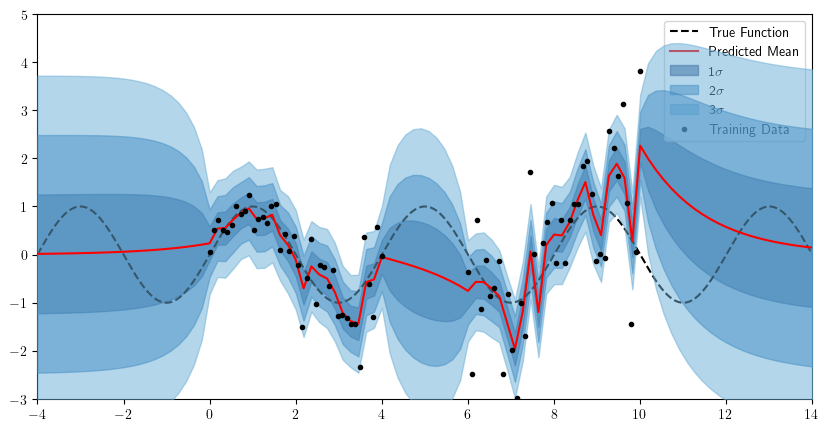

In [21]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()


cmap = plt.get_cmap('Blues')
colors = list(reversed([cmap(i) for i in np.linspace(0.5, 1, 3)]))
#fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_test = torch.linspace(-4, 14, 100, device=torch.device('cuda')).unsqueeze(1)

y_pred, y_std = gp_exp.predict(x_test, return_std=True)
y_samples = gp_exp.predict(x_test, num_samples=30)

print(y_samples.shape)

#for i, sample in enumerate(y_samples):
#    ax0.plot(to_numpy(x_test), to_numpy(sample), c=colors[2], alpha=0.5, zorder=i*5)

#ax0.plot(to_numpy(x_test), to_numpy(y_samples[-1]), c=colors[2], alpha=0.5, label='Sampled Functions')

#ax0.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=175)
#ax0.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=160)
ax1.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=15)
ax1.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=20)




for i, color in zip([1,2,3], colors):
    upper = y_pred.squeeze() + i * y_std
    lower = y_pred.squeeze() - i * y_std

    ax1.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color=color, label= f"{i}" + r'$\sigma$', zorder=i*5)

#ax0.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=200)
ax1.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=25)

#ax0.set_xlim(-4, 14)
#ax0.set_ylim(-2, 4)
ax1.set_xlim(-4, 14)
ax1.set_ylim(-3, 5)

#ax0.legend()
ax1.legend()

plt.show()